# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


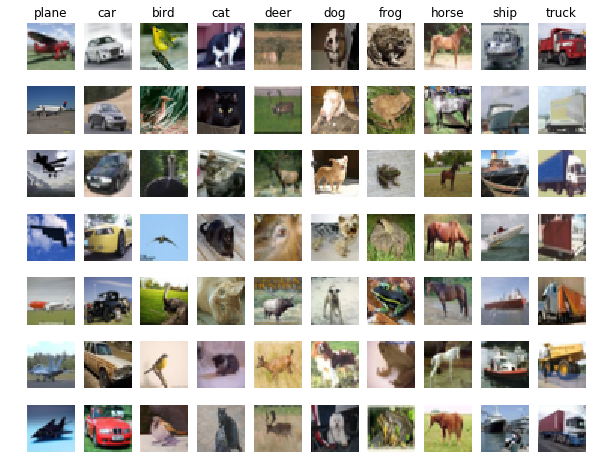

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


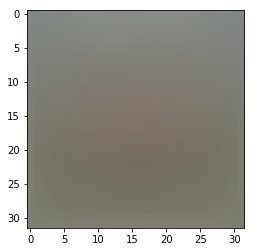

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: {}'.format(loss))

loss: 9.028172325070859


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [30]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -6.323573 analytic: -6.323573, relative error: 1.717956e-11
numerical: -9.248212 analytic: -9.248212, relative error: 8.013494e-12


numerical: 10.546535 analytic: 10.546535, relative error: 3.223387e-11
numerical: 3.621642 analytic: 3.621642, relative error: 1.132349e-10


numerical: -14.518685 analytic: -14.518685, relative error: 4.555386e-12
numerical: -28.510997 analytic: -28.510997, relative error: 1.178678e-11


numerical: -3.147927 analytic: -3.147927, relative error: 6.126590e-11
numerical: -51.867537 analytic: -51.867537, relative error: 1.460333e-13


numerical: -0.525041 analytic: -0.525041, relative error: 6.531270e-10
numerical: -19.449884 analytic: -19.449884, relative error: 3.451359e-12


numerical: -3.830159 analytic: -3.830159, relative error: 3.459560e-11
numerical: -30.878966 analytic: -30.878966, relative error: 3.752910e-12


numerical: 0.962412 analytic: 0.962412, relative error: 1.910920e-10
numerical: -2.984953 analytic: -2.984953, relative error: 7.056086e-11


numerical: 19.027047 analytic: 19.027047, relative error: 7.453921e-12
numerical: -27.479866 analytic: -27.479866, relative error: 3.096164e-12


numerical: 11.594731 analytic: 11.594731, relative error: 2.290090e-12
numerical: -15.868577 analytic: -15.868577, relative error: 2.388950e-11


numerical: 25.657970 analytic: 25.657970, relative error: 2.145851e-12
numerical: 16.298821 analytic: 16.298821, relative error: 1.196152e-11


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *The max function is not differentiable when sj-syi+delta is less than 0. At the kink, the finite difference, h, calculates a different gradient than the one in the analytical gradient. At this point, the gradient is very small, and so it is not much of a concern.*

In [31]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.028172e+00 computed in 0.051090s
Vectorized loss: 9.028172e+00 computed in 0.001768s
difference: 0.000000


In [36]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in {}s'.format((toc - tic)))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in {}s'.format((toc - tic)))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.05071401596069336s
Vectorized loss and gradient: computed in 0.007847309112548828s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [41]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 790.799987
iteration 100 / 1500: loss 473.935368


iteration 200 / 1500: loss 287.951441
iteration 300 / 1500: loss 175.424073


iteration 400 / 1500: loss 107.926976
iteration 500 / 1500: loss 67.076880


iteration 600 / 1500: loss 42.050049
iteration 700 / 1500: loss 28.027217


iteration 800 / 1500: loss 19.030517
iteration 900 / 1500: loss 13.738973


iteration 1000 / 1500: loss 10.933075
iteration 1100 / 1500: loss 8.149548


iteration 1200 / 1500: loss 7.108100
iteration 1300 / 1500: loss 6.434869


iteration 1400 / 1500: loss 5.911431
That took 1.990319s


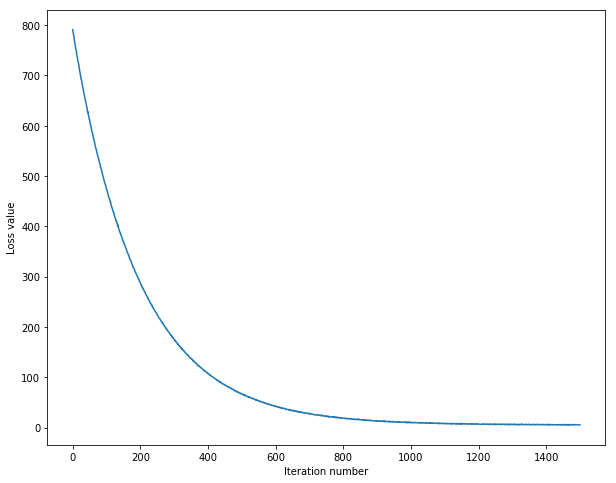

In [42]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [44]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.377449
validation accuracy: 0.389000


iteration 0 / 1500: loss 794.899086
iteration 100 / 1500: loss 474.862951


iteration 200 / 1500: loss 287.644314


iteration 300 / 1500: loss 175.578542
iteration 400 / 1500: loss 107.645075


iteration 500 / 1500: loss 67.167697
iteration 600 / 1500: loss 42.957195


iteration 700 / 1500: loss 27.728560
iteration 800 / 1500: loss 18.665651


iteration 900 / 1500: loss 13.302701
iteration 1000 / 1500: loss 10.181228


iteration 1100 / 1500: loss 8.139723
iteration 1200 / 1500: loss 7.920625


iteration 1300 / 1500: loss 6.863600
iteration 1400 / 1500: loss 6.284748


training accuracy: 0.38485714285714284
validation accuracy: 0.394
iteration 0 / 1500: loss 793.854395
iteration 100 / 1500: loss 473.497301


iteration 200 / 1500: loss 286.580983
iteration 300 / 1500: loss 174.509213


iteration 400 / 1500: loss 106.993875
iteration 500 / 1500: loss 66.638122


iteration 600 / 1500: loss 42.367976
iteration 700 / 1500: loss 27.179780


iteration 800 / 1500: loss 18.875847
iteration 900 / 1500: loss 14.036557


iteration 1000 / 1500: loss 10.075666
iteration 1100 / 1500: loss 8.116027


iteration 1200 / 1500: loss 7.089786
iteration 1300 / 1500: loss 6.519771


iteration 1400 / 1500: loss 6.129593


training accuracy: 0.38442857142857145
validation accuracy: 0.392
iteration 0 / 1500: loss 800.580530
iteration 100 / 1500: loss 479.884159


iteration 200 / 1500: loss 290.349061
iteration 300 / 1500: loss 176.368717


iteration 400 / 1500: loss 109.712267
iteration 500 / 1500: loss 67.305418


iteration 600 / 1500: loss 42.723996
iteration 700 / 1500: loss 28.193556


iteration 800 / 1500: loss 18.930649
iteration 900 / 1500: loss 13.957666


iteration 1000 / 1500: loss 10.681297
iteration 1100 / 1500: loss 8.365970


iteration 1200 / 1500: loss 7.041129
iteration 1300 / 1500: loss 6.755620


iteration 1400 / 1500: loss 6.437819
training accuracy: 0.3806326530612245
validation accuracy: 0.386
iteration 0 / 1500: loss 787.436314


iteration 100 / 1500: loss 472.372219


iteration 200 / 1500: loss 287.478477
iteration 300 / 1500: loss 174.948032


iteration 400 / 1500: loss 107.026839
iteration 500 / 1500: loss 66.823917


iteration 600 / 1500: loss 42.341264
iteration 700 / 1500: loss 27.296293


iteration 800 / 1500: loss 19.234432
iteration 900 / 1500: loss 13.521765


iteration 1000 / 1500: loss 10.160253
iteration 1100 / 1500: loss 8.446320


iteration 1200 / 1500: loss 7.198911
iteration 1300 / 1500: loss 6.126772


iteration 1400 / 1500: loss 5.632541


training accuracy: 0.37740816326530613
validation accuracy: 0.373
iteration 0 / 1500: loss 791.605251
iteration 100 / 1500: loss 468.676258


iteration 200 / 1500: loss 284.466625
iteration 300 / 1500: loss 172.650014


iteration 400 / 1500: loss 106.443302
iteration 500 / 1500: loss 66.379094


iteration 600 / 1500: loss 41.655406
iteration 700 / 1500: loss 27.699917


iteration 800 / 1500: loss 18.860142
iteration 900 / 1500: loss 13.214124


iteration 1000 / 1500: loss 10.303288
iteration 1100 / 1500: loss 7.863921


iteration 1200 / 1500: loss 7.404087
iteration 1300 / 1500: loss 6.488769


iteration 1400 / 1500: loss 5.912124


training accuracy: 0.38048979591836735
validation accuracy: 0.393
iteration 0 / 1500: loss 784.432980
iteration 100 / 1500: loss 470.180669


iteration 200 / 1500: loss 284.202565
iteration 300 / 1500: loss 174.410081


iteration 400 / 1500: loss 106.916630
iteration 500 / 1500: loss 66.737423


iteration 600 / 1500: loss 42.880351
iteration 700 / 1500: loss 27.425150


iteration 800 / 1500: loss 19.038462
iteration 900 / 1500: loss 13.278868


iteration 1000 / 1500: loss 10.165901
iteration 1100 / 1500: loss 8.225553


iteration 1200 / 1500: loss 7.195103
iteration 1300 / 1500: loss 6.549043


iteration 1400 / 1500: loss 6.038890
training accuracy: 0.3819387755102041
validation accuracy: 0.388


iteration 0 / 1500: loss 783.595597
iteration 100 / 1500: loss 469.272875


iteration 200 / 1500: loss 283.958506
iteration 300 / 1500: loss 172.934921


iteration 400 / 1500: loss 106.435111
iteration 500 / 1500: loss 66.371001


iteration 600 / 1500: loss 42.197432
iteration 700 / 1500: loss 27.042303


iteration 800 / 1500: loss 18.954800
iteration 900 / 1500: loss 13.753349


iteration 1000 / 1500: loss 10.205500
iteration 1100 / 1500: loss 8.209246


iteration 1200 / 1500: loss 7.098102
iteration 1300 / 1500: loss 7.161404


iteration 1400 / 1500: loss 6.026651
training accuracy: 0.3826122448979592
validation accuracy: 0.381
iteration 0 / 1500: loss 801.251854


iteration 100 / 1500: loss 474.332102
iteration 200 / 1500: loss 288.009898


iteration 300 / 1500: loss 175.831569
iteration 400 / 1500: loss 107.307889


iteration 500 / 1500: loss 67.205001
iteration 600 / 1500: loss 42.370295


iteration 700 / 1500: loss 27.878030
iteration 800 / 1500: loss 18.837860


iteration 900 / 1500: loss 14.119457
iteration 1000 / 1500: loss 10.791331


iteration 1100 / 1500: loss 8.356502
iteration 1200 / 1500: loss 7.004726


iteration 1300 / 1500: loss 6.089908
iteration 1400 / 1500: loss 6.062496


training accuracy: 0.3786122448979592
validation accuracy: 0.396
iteration 0 / 1500: loss 780.923691
iteration 100 / 1500: loss 465.675895


iteration 200 / 1500: loss 283.376042
iteration 300 / 1500: loss 172.266006


iteration 400 / 1500: loss 106.302288
iteration 500 / 1500: loss 66.586162


iteration 600 / 1500: loss 42.013524
iteration 700 / 1500: loss 27.190676


iteration 800 / 1500: loss 18.595038
iteration 900 / 1500: loss 13.121375


iteration 1000 / 1500: loss 10.645622
iteration 1100 / 1500: loss 8.493449


iteration 1200 / 1500: loss 7.515281
iteration 1300 / 1500: loss 6.535643


iteration 1400 / 1500: loss 5.785523
training accuracy: 0.3790816326530612
validation accuracy: 0.375


iteration 0 / 1500: loss 791.922729
iteration 100 / 1500: loss 473.790037


iteration 200 / 1500: loss 286.787214
iteration 300 / 1500: loss 174.003373


iteration 400 / 1500: loss 108.070686
iteration 500 / 1500: loss 67.403788


iteration 600 / 1500: loss 42.179505
iteration 700 / 1500: loss 28.171706


iteration 800 / 1500: loss 19.346082
iteration 900 / 1500: loss 13.521409


iteration 1000 / 1500: loss 10.261165
iteration 1100 / 1500: loss 8.542229


iteration 1200 / 1500: loss 7.363796
iteration 1300 / 1500: loss 6.337815


iteration 1400 / 1500: loss 6.072294
training accuracy: 0.37812244897959185
validation accuracy: 0.371


iteration 0 / 1500: loss 793.441954
iteration 100 / 1500: loss 475.510588


iteration 200 / 1500: loss 288.364592
iteration 300 / 1500: loss 174.560732


iteration 400 / 1500: loss 107.640477
iteration 500 / 1500: loss 67.410541


iteration 600 / 1500: loss 42.484948
iteration 700 / 1500: loss 27.944967


iteration 800 / 1500: loss 19.001940
iteration 900 / 1500: loss 13.560685


iteration 1000 / 1500: loss 10.165026
iteration 1100 / 1500: loss 8.585636


iteration 1200 / 1500: loss 7.002166
iteration 1300 / 1500: loss 6.884961


iteration 1400 / 1500: loss 6.431450


training accuracy: 0.3780612244897959
validation accuracy: 0.382
iteration 0 / 1500: loss 801.918089
iteration 100 / 1500: loss 476.124120


iteration 200 / 1500: loss 289.561059
iteration 300 / 1500: loss 176.313429


iteration 400 / 1500: loss 108.606731
iteration 500 / 1500: loss 67.893375


iteration 600 / 1500: loss 42.815593
iteration 700 / 1500: loss 27.468070


iteration 800 / 1500: loss 18.751249
iteration 900 / 1500: loss 13.128657


iteration 1000 / 1500: loss 10.683764
iteration 1100 / 1500: loss 8.301966


iteration 1200 / 1500: loss 7.115294
iteration 1300 / 1500: loss 6.411308


iteration 1400 / 1500: loss 6.350287
training accuracy: 0.38124489795918365
validation accuracy: 0.383


iteration 0 / 1500: loss 799.969300
iteration 100 / 1500: loss 474.590972


iteration 200 / 1500: loss 288.250303
iteration 300 / 1500: loss 175.433332


iteration 400 / 1500: loss 107.603179
iteration 500 / 1500: loss 67.687907


iteration 600 / 1500: loss 42.780915
iteration 700 / 1500: loss 28.148947


iteration 800 / 1500: loss 18.921399
iteration 900 / 1500: loss 13.353617


iteration 1000 / 1500: loss 10.045035
iteration 1100 / 1500: loss 8.637501


iteration 1200 / 1500: loss 7.369474
iteration 1300 / 1500: loss 6.165937


iteration 1400 / 1500: loss 5.886276
training accuracy: 0.38016326530612243
validation accuracy: 0.386
iteration 0 / 1500: loss 791.222234


iteration 100 / 1500: loss 471.300815
iteration 200 / 1500: loss 286.497429


iteration 300 / 1500: loss 174.166647
iteration 400 / 1500: loss 106.952227


iteration 500 / 1500: loss 67.478380
iteration 600 / 1500: loss 42.305407


iteration 700 / 1500: loss 27.476289
iteration 800 / 1500: loss 18.472066


iteration 900 / 1500: loss 13.133819
iteration 1000 / 1500: loss 10.222876


iteration 1100 / 1500: loss 8.389756
iteration 1200 / 1500: loss 7.252018


iteration 1300 / 1500: loss 6.507219
iteration 1400 / 1500: loss 6.371760


training accuracy: 0.3793877551020408
validation accuracy: 0.387
iteration 0 / 1500: loss 795.543878
iteration 100 / 1500: loss 475.970052


iteration 200 / 1500: loss 288.040472
iteration 300 / 1500: loss 175.605508


iteration 400 / 1500: loss 108.048568
iteration 500 / 1500: loss 67.480731


iteration 600 / 1500: loss 42.702510
iteration 700 / 1500: loss 27.822113


iteration 800 / 1500: loss 18.936167
iteration 900 / 1500: loss 13.956590


iteration 1000 / 1500: loss 10.334998
iteration 1100 / 1500: loss 8.795899


iteration 1200 / 1500: loss 7.051316
iteration 1300 / 1500: loss 6.314556


iteration 1400 / 1500: loss 5.868745


training accuracy: 0.38018367346938775
validation accuracy: 0.381
iteration 0 / 1500: loss 786.262946
iteration 100 / 1500: loss 469.727893


iteration 200 / 1500: loss 285.013518
iteration 300 / 1500: loss 173.306371


iteration 400 / 1500: loss 107.172945
iteration 500 / 1500: loss 66.010552


iteration 600 / 1500: loss 42.739198
iteration 700 / 1500: loss 27.406425


iteration 800 / 1500: loss 18.891588
iteration 900 / 1500: loss 13.103189


iteration 1000 / 1500: loss 10.044966
iteration 1100 / 1500: loss 8.224057


iteration 1200 / 1500: loss 6.847080
iteration 1300 / 1500: loss 6.845694


iteration 1400 / 1500: loss 5.316149


training accuracy: 0.38112244897959185
validation accuracy: 0.381
iteration 0 / 1500: loss 788.853449
iteration 100 / 1500: loss 471.898203


iteration 200 / 1500: loss 284.984252
iteration 300 / 1500: loss 173.755242


iteration 400 / 1500: loss 107.218866
iteration 500 / 1500: loss 66.162947


iteration 600 / 1500: loss 42.735793
iteration 700 / 1500: loss 27.273672


iteration 800 / 1500: loss 18.581251
iteration 900 / 1500: loss 13.621407


iteration 1000 / 1500: loss 9.617100
iteration 1100 / 1500: loss 8.532417


iteration 1200 / 1500: loss 7.395227
iteration 1300 / 1500: loss 6.921023


iteration 1400 / 1500: loss 5.779277
training accuracy: 0.381
validation accuracy: 0.388
iteration 0 / 1500: loss 790.315266


iteration 100 / 1500: loss 476.023387


iteration 200 / 1500: loss 287.593986
iteration 300 / 1500: loss 176.665498


iteration 400 / 1500: loss 108.250250
iteration 500 / 1500: loss 67.284141


iteration 600 / 1500: loss 42.547325
iteration 700 / 1500: loss 28.281557


iteration 800 / 1500: loss 18.937395
iteration 900 / 1500: loss 13.672469


iteration 1000 / 1500: loss 9.851736
iteration 1100 / 1500: loss 8.449138


iteration 1200 / 1500: loss 7.565128
iteration 1300 / 1500: loss 6.386177


iteration 1400 / 1500: loss 5.421045


training accuracy: 0.38285714285714284
validation accuracy: 0.382
iteration 0 / 1500: loss 786.921785
iteration 100 / 1500: loss 471.461958


iteration 200 / 1500: loss 285.518000
iteration 300 / 1500: loss 173.779912


iteration 400 / 1500: loss 107.233885
iteration 500 / 1500: loss 66.126769


iteration 600 / 1500: loss 42.073581
iteration 700 / 1500: loss 27.523004


iteration 800 / 1500: loss 18.937363
iteration 900 / 1500: loss 13.347544


iteration 1000 / 1500: loss 10.196010
iteration 1100 / 1500: loss 8.138388


iteration 1200 / 1500: loss 7.158281
iteration 1300 / 1500: loss 6.218644


iteration 1400 / 1500: loss 6.079618


training accuracy: 0.3804489795918367
validation accuracy: 0.389
iteration 0 / 1500: loss 779.968766
iteration 100 / 1500: loss 468.260402


iteration 200 / 1500: loss 283.494907
iteration 300 / 1500: loss 173.353066


iteration 400 / 1500: loss 105.861184
iteration 500 / 1500: loss 66.324052


iteration 600 / 1500: loss 41.552253
iteration 700 / 1500: loss 26.955744


iteration 800 / 1500: loss 18.549481
iteration 900 / 1500: loss 13.096513


iteration 1000 / 1500: loss 10.241670
iteration 1100 / 1500: loss 7.942410


iteration 1200 / 1500: loss 6.504371
iteration 1300 / 1500: loss 6.366753


iteration 1400 / 1500: loss 5.695434
training accuracy: 0.3873061224489796


validation accuracy: 0.386
iteration 0 / 1500: loss 789.252536
iteration 100 / 1500: loss 470.317478


iteration 200 / 1500: loss 284.460213
iteration 300 / 1500: loss 172.833908


iteration 400 / 1500: loss 107.075439
iteration 500 / 1500: loss 67.082699


iteration 600 / 1500: loss 42.473520
iteration 700 / 1500: loss 28.139507


iteration 800 / 1500: loss 18.699299
iteration 900 / 1500: loss 13.270907


iteration 1000 / 1500: loss 10.502756
iteration 1100 / 1500: loss 8.453703


iteration 1200 / 1500: loss 7.531834
iteration 1300 / 1500: loss 6.100040


iteration 1400 / 1500: loss 5.650149
training accuracy: 0.3807755102040816
validation accuracy: 0.382


iteration 0 / 1500: loss 803.030868
iteration 100 / 1500: loss 478.582607


iteration 200 / 1500: loss 290.791371
iteration 300 / 1500: loss 176.596276


iteration 400 / 1500: loss 108.642730
iteration 500 / 1500: loss 66.965399


iteration 600 / 1500: loss 42.784559
iteration 700 / 1500: loss 27.923144


iteration 800 / 1500: loss 19.031313
iteration 900 / 1500: loss 13.674669


iteration 1000 / 1500: loss 10.096978
iteration 1100 / 1500: loss 7.888738


iteration 1200 / 1500: loss 7.528855
iteration 1300 / 1500: loss 6.638707


iteration 1400 / 1500: loss 5.973837


training accuracy: 0.3801428571428571
validation accuracy: 0.396
iteration 0 / 1500: loss 783.074186
iteration 100 / 1500: loss 469.377977


iteration 200 / 1500: loss 285.351322
iteration 300 / 1500: loss 173.617510


iteration 400 / 1500: loss 105.850116
iteration 500 / 1500: loss 65.736550


iteration 600 / 1500: loss 41.957591
iteration 700 / 1500: loss 27.126240


iteration 800 / 1500: loss 18.656359
iteration 900 / 1500: loss 13.663606


iteration 1000 / 1500: loss 10.257100
iteration 1100 / 1500: loss 8.640072


iteration 1200 / 1500: loss 7.152494
iteration 1300 / 1500: loss 6.540382


iteration 1400 / 1500: loss 6.038824


training accuracy: 0.3795918367346939
validation accuracy: 0.387
iteration 0 / 1500: loss 805.048696
iteration 100 / 1500: loss 478.994787


iteration 200 / 1500: loss 289.990246
iteration 300 / 1500: loss 177.213140


iteration 400 / 1500: loss 109.246761
iteration 500 / 1500: loss 67.327675


iteration 600 / 1500: loss 43.109703
iteration 700 / 1500: loss 27.755282


iteration 800 / 1500: loss 19.082380
iteration 900 / 1500: loss 13.212706


iteration 1000 / 1500: loss 10.300011
iteration 1100 / 1500: loss 8.978994


iteration 1200 / 1500: loss 6.426104
iteration 1300 / 1500: loss 6.761061


iteration 1400 / 1500: loss 7.045604


training accuracy: 0.381530612244898
validation accuracy: 0.378
iteration 0 / 1500: loss 787.688112
iteration 100 / 1500: loss 468.352862


iteration 200 / 1500: loss 285.220577
iteration 300 / 1500: loss 173.756090


iteration 400 / 1500: loss 106.518878
iteration 500 / 1500: loss 66.166105


iteration 600 / 1500: loss 42.140720
iteration 700 / 1500: loss 28.119057


iteration 800 / 1500: loss 18.222816
iteration 900 / 1500: loss 13.498875


iteration 1000 / 1500: loss 10.368694
iteration 1100 / 1500: loss 8.763893


iteration 1200 / 1500: loss 6.871883
iteration 1300 / 1500: loss 6.456421


iteration 1400 / 1500: loss 6.197547
training accuracy: 0.3806734693877551


validation accuracy: 0.391
iteration 0 / 1500: loss 780.053739
iteration 100 / 1500: loss 468.079736


iteration 200 / 1500: loss 284.006415
iteration 300 / 1500: loss 173.417502


iteration 400 / 1500: loss 106.785466
iteration 500 / 1500: loss 66.096269


iteration 600 / 1500: loss 42.598916
iteration 700 / 1500: loss 27.437211


iteration 800 / 1500: loss 18.824136
iteration 900 / 1500: loss 12.666579


iteration 1000 / 1500: loss 10.826560
iteration 1100 / 1500: loss 8.360624


iteration 1200 / 1500: loss 7.539480
iteration 1300 / 1500: loss 7.068832


iteration 1400 / 1500: loss 5.632651
training accuracy: 0.3766938775510204
validation accuracy: 0.389


iteration 0 / 1500: loss 803.529477
iteration 100 / 1500: loss 477.741489


iteration 200 / 1500: loss 289.255835
iteration 300 / 1500: loss 177.021842


iteration 400 / 1500: loss 108.313212
iteration 500 / 1500: loss 66.755829


iteration 600 / 1500: loss 42.706219
iteration 700 / 1500: loss 28.118485


iteration 800 / 1500: loss 18.707784
iteration 900 / 1500: loss 14.064743


iteration 1000 / 1500: loss 10.414096
iteration 1100 / 1500: loss 8.233969


iteration 1200 / 1500: loss 7.150337
iteration 1300 / 1500: loss 6.295126


iteration 1400 / 1500: loss 5.990657
training accuracy: 0.3828979591836735
validation accuracy: 0.387


iteration 0 / 1500: loss 793.535335
iteration 100 / 1500: loss 474.346094


iteration 200 / 1500: loss 288.696068
iteration 300 / 1500: loss 175.048135


iteration 400 / 1500: loss 108.569089
iteration 500 / 1500: loss 67.440548


iteration 600 / 1500: loss 42.753257
iteration 700 / 1500: loss 27.915833


iteration 800 / 1500: loss 18.799677
iteration 900 / 1500: loss 14.284052


iteration 1000 / 1500: loss 10.316571
iteration 1100 / 1500: loss 7.819225


iteration 1200 / 1500: loss 6.908275
iteration 1300 / 1500: loss 6.385904


iteration 1400 / 1500: loss 6.173647
training accuracy: 0.38026530612244897
validation accuracy: 0.371
iteration 0 / 1500: loss 789.492995


iteration 100 / 1500: loss 471.740504
iteration 200 / 1500: loss 286.486249


iteration 300 / 1500: loss 174.493730
iteration 400 / 1500: loss 107.342895


iteration 500 / 1500: loss 66.830577
iteration 600 / 1500: loss 41.875505


iteration 700 / 1500: loss 27.587604
iteration 800 / 1500: loss 19.076312


iteration 900 / 1500: loss 13.698981
iteration 1000 / 1500: loss 10.473762


iteration 1100 / 1500: loss 8.377626
iteration 1200 / 1500: loss 7.588096


iteration 1300 / 1500: loss 6.479805
iteration 1400 / 1500: loss 5.666676


training accuracy: 0.3782857142857143
validation accuracy: 0.394
iteration 0 / 1500: loss 794.199591
iteration 100 / 1500: loss 472.873789


iteration 200 / 1500: loss 286.862919
iteration 300 / 1500: loss 175.141101


iteration 400 / 1500: loss 107.612049
iteration 500 / 1500: loss 66.664587


iteration 600 / 1500: loss 42.681337
iteration 700 / 1500: loss 27.650057


iteration 800 / 1500: loss 18.556978
iteration 900 / 1500: loss 13.352125


iteration 1000 / 1500: loss 10.883855


iteration 1100 / 1500: loss 8.675394
iteration 1200 / 1500: loss 7.011431


iteration 1300 / 1500: loss 6.259084
iteration 1400 / 1500: loss 5.921219


training accuracy: 0.3783877551020408
validation accuracy: 0.387
iteration 0 / 1500: loss 790.787919
iteration 100 / 1500: loss 470.023225


iteration 200 / 1500: loss 286.102698
iteration 300 / 1500: loss 173.931102


iteration 400 / 1500: loss 106.940353
iteration 500 / 1500: loss 66.263320


iteration 600 / 1500: loss 42.234423
iteration 700 / 1500: loss 27.458388


iteration 800 / 1500: loss 18.454384
iteration 900 / 1500: loss 13.679490


iteration 1000 / 1500: loss 9.942200
iteration 1100 / 1500: loss 8.420219


iteration 1200 / 1500: loss 7.087918
iteration 1300 / 1500: loss 6.392907


iteration 1400 / 1500: loss 5.756817
training accuracy: 0.37940816326530613
validation accuracy: 0.372


iteration 0 / 1500: loss 786.322518
iteration 100 / 1500: loss 468.407010


iteration 200 / 1500: loss 284.273099
iteration 300 / 1500: loss 173.615714


iteration 400 / 1500: loss 105.932856
iteration 500 / 1500: loss 66.685574


iteration 600 / 1500: loss 42.317620
iteration 700 / 1500: loss 27.589498


iteration 800 / 1500: loss 18.996970
iteration 900 / 1500: loss 13.214345


iteration 1000 / 1500: loss 10.396895
iteration 1100 / 1500: loss 8.337178


iteration 1200 / 1500: loss 6.942272
iteration 1300 / 1500: loss 6.060473


iteration 1400 / 1500: loss 6.122548
training accuracy: 0.3833469387755102
validation accuracy: 0.399
iteration 0 / 1500: loss 786.195870


iteration 100 / 1500: loss 470.721074


iteration 200 / 1500: loss 285.847201
iteration 300 / 1500: loss 173.390513


iteration 400 / 1500: loss 106.941391
iteration 500 / 1500: loss 66.230256


iteration 600 / 1500: loss 42.006116
iteration 700 / 1500: loss 28.104291


iteration 800 / 1500: loss 18.679462
iteration 900 / 1500: loss 13.281969


iteration 1000 / 1500: loss 10.291954
iteration 1100 / 1500: loss 8.760600


iteration 1200 / 1500: loss 7.159246
iteration 1300 / 1500: loss 6.692958


iteration 1400 / 1500: loss 5.930424
training accuracy: 0.3843469387755102
validation accuracy: 0.393
iteration 0 / 1500: loss 800.381684


iteration 100 / 1500: loss 477.762473
iteration 200 / 1500: loss 288.938236


iteration 300 / 1500: loss 176.600263
iteration 400 / 1500: loss 108.242869


iteration 500 / 1500: loss 67.672823
iteration 600 / 1500: loss 42.786297


iteration 700 / 1500: loss 27.970019
iteration 800 / 1500: loss 19.095649


iteration 900 / 1500: loss 13.805471
iteration 1000 / 1500: loss 10.806464


iteration 1100 / 1500: loss 8.267684
iteration 1200 / 1500: loss 7.048989


iteration 1300 / 1500: loss 6.380389
iteration 1400 / 1500: loss 6.241177


training accuracy: 0.3772448979591837
validation accuracy: 0.394
iteration 0 / 1500: loss 783.940816
iteration 100 / 1500: loss 468.604396


iteration 200 / 1500: loss 284.621017
iteration 300 / 1500: loss 173.491213


iteration 400 / 1500: loss 106.466031
iteration 500 / 1500: loss 66.150291


iteration 600 / 1500: loss 41.510445
iteration 700 / 1500: loss 27.080315


iteration 800 / 1500: loss 18.680221
iteration 900 / 1500: loss 14.232333


iteration 1000 / 1500: loss 10.294977
iteration 1100 / 1500: loss 8.352842


iteration 1200 / 1500: loss 7.750696
iteration 1300 / 1500: loss 6.139120


iteration 1400 / 1500: loss 5.826158


training accuracy: 0.3799795918367347
validation accuracy: 0.391
iteration 0 / 1500: loss 802.588685
iteration 100 / 1500: loss 478.832972


iteration 200 / 1500: loss 290.728688
iteration 300 / 1500: loss 176.733623


iteration 400 / 1500: loss 108.908802
iteration 500 / 1500: loss 67.995203


iteration 600 / 1500: loss 42.967027
iteration 700 / 1500: loss 27.820717


iteration 800 / 1500: loss 19.067694
iteration 900 / 1500: loss 13.824939


iteration 1000 / 1500: loss 10.268095
iteration 1100 / 1500: loss 8.348600


iteration 1200 / 1500: loss 7.532719
iteration 1300 / 1500: loss 6.281921


iteration 1400 / 1500: loss 5.598678
training accuracy: 0.3796734693877551
validation accuracy: 0.384


iteration 0 / 1500: loss 796.092439
iteration 100 / 1500: loss 476.658984


iteration 200 / 1500: loss 288.824319
iteration 300 / 1500: loss 175.940266


iteration 400 / 1500: loss 108.365481
iteration 500 / 1500: loss 67.314440


iteration 600 / 1500: loss 41.646569
iteration 700 / 1500: loss 27.918054


iteration 800 / 1500: loss 19.817436
iteration 900 / 1500: loss 12.902401


iteration 1000 / 1500: loss 10.193120
iteration 1100 / 1500: loss 8.484910


iteration 1200 / 1500: loss 6.978241
iteration 1300 / 1500: loss 6.568230


iteration 1400 / 1500: loss 6.083442
training accuracy: 0.37981632653061226
validation accuracy: 0.376
iteration 0 / 1500: loss 792.675271


iteration 100 / 1500: loss 473.498922
iteration 200 / 1500: loss 287.530346


iteration 300 / 1500: loss 175.138310
iteration 400 / 1500: loss 107.613732


iteration 500 / 1500: loss 68.091701
iteration 600 / 1500: loss 42.472955


iteration 700 / 1500: loss 28.138976
iteration 800 / 1500: loss 18.460080


iteration 900 / 1500: loss 13.679337
iteration 1000 / 1500: loss 10.327474


iteration 1100 / 1500: loss 8.134879
iteration 1200 / 1500: loss 6.652519


iteration 1300 / 1500: loss 6.529507
iteration 1400 / 1500: loss 5.977730


training accuracy: 0.37757142857142856
validation accuracy: 0.381
iteration 0 / 1500: loss 783.098379
iteration 100 / 1500: loss 466.179342


iteration 200 / 1500: loss 282.522122
iteration 300 / 1500: loss 172.862318


iteration 400 / 1500: loss 106.218553
iteration 500 / 1500: loss 65.843889


iteration 600 / 1500: loss 42.156637
iteration 700 / 1500: loss 27.151444


iteration 800 / 1500: loss 18.550595
iteration 900 / 1500: loss 13.250073


iteration 1000 / 1500: loss 10.234847
iteration 1100 / 1500: loss 8.295954


iteration 1200 / 1500: loss 7.157843
iteration 1300 / 1500: loss 6.115193


iteration 1400 / 1500: loss 5.785634
training accuracy: 0.3831428571428571


validation accuracy: 0.388
iteration 0 / 1500: loss 796.871880
iteration 100 / 1500: loss 473.512164


iteration 200 / 1500: loss 288.389403
iteration 300 / 1500: loss 175.235667


iteration 400 / 1500: loss 107.703099
iteration 500 / 1500: loss 67.131114


iteration 600 / 1500: loss 41.897488
iteration 700 / 1500: loss 27.257234


iteration 800 / 1500: loss 18.507632
iteration 900 / 1500: loss 13.823991


iteration 1000 / 1500: loss 10.145204
iteration 1100 / 1500: loss 8.235622


iteration 1200 / 1500: loss 6.853393
iteration 1300 / 1500: loss 6.765531


iteration 1400 / 1500: loss 5.818982
training accuracy: 0.38257142857142856
validation accuracy: 0.391


iteration 0 / 1500: loss 799.307390
iteration 100 / 1500: loss 474.731196


iteration 200 / 1500: loss 287.624610
iteration 300 / 1500: loss 174.829452


iteration 400 / 1500: loss 107.295617
iteration 500 / 1500: loss 66.725756


iteration 600 / 1500: loss 42.196938
iteration 700 / 1500: loss 28.048270


iteration 800 / 1500: loss 18.991291
iteration 900 / 1500: loss 13.480352


iteration 1000 / 1500: loss 10.166475
iteration 1100 / 1500: loss 8.575934


iteration 1200 / 1500: loss 7.268772
iteration 1300 / 1500: loss 6.621989


iteration 1400 / 1500: loss 5.777016


training accuracy: 0.3799183673469388
validation accuracy: 0.381
iteration 0 / 1500: loss 787.609553
iteration 100 / 1500: loss 470.450911


iteration 200 / 1500: loss 284.148038
iteration 300 / 1500: loss 174.028687


iteration 400 / 1500: loss 106.635804
iteration 500 / 1500: loss 66.202043


iteration 600 / 1500: loss 42.358634
iteration 700 / 1500: loss 27.715065


iteration 800 / 1500: loss 18.915123
iteration 900 / 1500: loss 13.407622


iteration 1000 / 1500: loss 10.264090
iteration 1100 / 1500: loss 8.020375


iteration 1200 / 1500: loss 6.992351
iteration 1300 / 1500: loss 6.922733


iteration 1400 / 1500: loss 6.185208
training accuracy: 0.37857142857142856
validation accuracy: 0.391


iteration 0 / 1500: loss 780.972692
iteration 100 / 1500: loss 469.029774


iteration 200 / 1500: loss 284.672951
iteration 300 / 1500: loss 174.199261


iteration 400 / 1500: loss 106.741985
iteration 500 / 1500: loss 66.283390


iteration 600 / 1500: loss 41.874316
iteration 700 / 1500: loss 27.188667


iteration 800 / 1500: loss 18.470448
iteration 900 / 1500: loss 13.322454


iteration 1000 / 1500: loss 10.205872
iteration 1100 / 1500: loss 8.275672


iteration 1200 / 1500: loss 7.055380
iteration 1300 / 1500: loss 6.278909


iteration 1400 / 1500: loss 5.867546
training accuracy: 0.38455102040816325


validation accuracy: 0.383
iteration 0 / 1500: loss 789.723663
iteration 100 / 1500: loss 471.741745


iteration 200 / 1500: loss 285.325702
iteration 300 / 1500: loss 174.228297


iteration 400 / 1500: loss 106.983177
iteration 500 / 1500: loss 66.548139


iteration 600 / 1500: loss 42.051628
iteration 700 / 1500: loss 27.481879


iteration 800 / 1500: loss 18.475846
iteration 900 / 1500: loss 14.103322


iteration 1000 / 1500: loss 10.239958
iteration 1100 / 1500: loss 8.250242


iteration 1200 / 1500: loss 6.633960
iteration 1300 / 1500: loss 6.130042


iteration 1400 / 1500: loss 6.367249
training accuracy: 0.3765918367346939
validation accuracy: 0.393


iteration 0 / 1500: loss 790.652913
iteration 100 / 1500: loss 468.942216


iteration 200 / 1500: loss 284.790087
iteration 300 / 1500: loss 174.428493


iteration 400 / 1500: loss 107.266806
iteration 500 / 1500: loss 67.395206


iteration 600 / 1500: loss 42.236523
iteration 700 / 1500: loss 28.119035


iteration 800 / 1500: loss 18.910824
iteration 900 / 1500: loss 13.736222


iteration 1000 / 1500: loss 10.428216
iteration 1100 / 1500: loss 8.201813


iteration 1200 / 1500: loss 7.320586
iteration 1300 / 1500: loss 6.684002


iteration 1400 / 1500: loss 6.210755
training accuracy: 0.3821428571428571
validation accuracy: 0.381
iteration 0 / 1500: loss 802.654585


iteration 100 / 1500: loss 480.485845
iteration 200 / 1500: loss 291.114364


iteration 300 / 1500: loss 176.558536
iteration 400 / 1500: loss 109.760513


iteration 500 / 1500: loss 68.009097
iteration 600 / 1500: loss 43.027371


iteration 700 / 1500: loss 28.131051
iteration 800 / 1500: loss 18.913011


iteration 900 / 1500: loss 13.943507
iteration 1000 / 1500: loss 10.448187


iteration 1100 / 1500: loss 8.331214
iteration 1200 / 1500: loss 6.851875


iteration 1300 / 1500: loss 6.637299
iteration 1400 / 1500: loss 6.274051


training accuracy: 0.38048979591836735
validation accuracy: 0.386
iteration 0 / 1500: loss 784.559561
iteration 100 / 1500: loss 467.177486


iteration 200 / 1500: loss 282.509389
iteration 300 / 1500: loss 172.067590


iteration 400 / 1500: loss 105.798261
iteration 500 / 1500: loss 66.298876


iteration 600 / 1500: loss 41.549748
iteration 700 / 1500: loss 27.485849


iteration 800 / 1500: loss 18.406752
iteration 900 / 1500: loss 13.252002


iteration 1000 / 1500: loss 10.010910
iteration 1100 / 1500: loss 8.313538


iteration 1200 / 1500: loss 7.359369
iteration 1300 / 1500: loss 6.829680


iteration 1400 / 1500: loss 5.727325
training accuracy: 0.3817755102040816


validation accuracy: 0.382
iteration 0 / 1500: loss 788.092309
iteration 100 / 1500: loss 472.727277


iteration 200 / 1500: loss 286.092687
iteration 300 / 1500: loss 174.836448


iteration 400 / 1500: loss 107.535065
iteration 500 / 1500: loss 66.331900


iteration 600 / 1500: loss 42.707263
iteration 700 / 1500: loss 27.936046


iteration 800 / 1500: loss 18.747361
iteration 900 / 1500: loss 13.415264


iteration 1000 / 1500: loss 9.818676
iteration 1100 / 1500: loss 8.265479


iteration 1200 / 1500: loss 6.913413
iteration 1300 / 1500: loss 6.887957


iteration 1400 / 1500: loss 5.911459


training accuracy: 0.38081632653061226
validation accuracy: 0.404
iteration 0 / 1500: loss 793.323443
iteration 100 / 1500: loss 473.225384


iteration 200 / 1500: loss 286.830298
iteration 300 / 1500: loss 174.888264


iteration 400 / 1500: loss 107.677505
iteration 500 / 1500: loss 66.605504


iteration 600 / 1500: loss 42.569671
iteration 700 / 1500: loss 27.641971


iteration 800 / 1500: loss 19.081069
iteration 900 / 1500: loss 12.916745


iteration 1000 / 1500: loss 10.260588
iteration 1100 / 1500: loss 8.646467


iteration 1200 / 1500: loss 6.952909
iteration 1300 / 1500: loss 6.483684


iteration 1400 / 1500: loss 6.248232
training accuracy: 0.3860204081632653


validation accuracy: 0.399
iteration 0 / 1500: loss 790.374870
iteration 100 / 1500: loss 470.171616


iteration 200 / 1500: loss 284.402131
iteration 300 / 1500: loss 173.659836


iteration 400 / 1500: loss 106.033562
iteration 500 / 1500: loss 66.629367


iteration 600 / 1500: loss 42.053666
iteration 700 / 1500: loss 27.710598


iteration 800 / 1500: loss 18.511603
iteration 900 / 1500: loss 13.614010


iteration 1000 / 1500: loss 10.185083
iteration 1100 / 1500: loss 8.497387


iteration 1200 / 1500: loss 7.400115
iteration 1300 / 1500: loss 6.603490


iteration 1400 / 1500: loss 6.477191


training accuracy: 0.37920408163265307
validation accuracy: 0.381
iteration 0 / 1500: loss 794.502280
iteration 100 / 1500: loss 474.096296


iteration 200 / 1500: loss 288.357853
iteration 300 / 1500: loss 176.142482


iteration 400 / 1500: loss 108.155614
iteration 500 / 1500: loss 67.455828


iteration 600 / 1500: loss 42.578502
iteration 700 / 1500: loss 28.044132


iteration 800 / 1500: loss 19.430993
iteration 900 / 1500: loss 13.828094


iteration 1000 / 1500: loss 10.125013
iteration 1100 / 1500: loss 8.947121


iteration 1200 / 1500: loss 7.459305
iteration 1300 / 1500: loss 6.189752


iteration 1400 / 1500: loss 6.180057


training accuracy: 0.37814285714285717
validation accuracy: 0.373
iteration 0 / 1500: loss 787.361753
iteration 100 / 1500: loss 468.134184


iteration 200 / 1500: loss 284.017891
iteration 300 / 1500: loss 173.459210


iteration 400 / 1500: loss 107.215425
iteration 500 / 1500: loss 66.153525


iteration 600 / 1500: loss 42.327650
iteration 700 / 1500: loss 27.604808


iteration 800 / 1500: loss 19.074665
iteration 900 / 1500: loss 13.571839


iteration 1000 / 1500: loss 10.482975
iteration 1100 / 1500: loss 8.282677


iteration 1200 / 1500: loss 7.495364
iteration 1300 / 1500: loss 6.397082


iteration 1400 / 1500: loss 6.340901
training accuracy: 0.3820612244897959
validation accuracy: 0.387


iteration 0 / 1500: loss 783.549839
iteration 100 / 1500: loss 470.735528


iteration 200 / 1500: loss 286.587914
iteration 300 / 1500: loss 173.529842


iteration 400 / 1500: loss 107.163540
iteration 500 / 1500: loss 66.187146


iteration 600 / 1500: loss 41.654733
iteration 700 / 1500: loss 27.453163


iteration 800 / 1500: loss 19.044628
iteration 900 / 1500: loss 13.883346


iteration 1000 / 1500: loss 9.668177
iteration 1100 / 1500: loss 8.663940


iteration 1200 / 1500: loss 6.819467
iteration 1300 / 1500: loss 5.925255


iteration 1400 / 1500: loss 6.330851


training accuracy: 0.38087755102040816
validation accuracy: 0.384
iteration 0 / 1500: loss 785.774914
iteration 100 / 1500: loss 470.241150


iteration 200 / 1500: loss 285.303746
iteration 300 / 1500: loss 173.488902


iteration 400 / 1500: loss 107.320671
iteration 500 / 1500: loss 66.610683


iteration 600 / 1500: loss 41.916141
iteration 700 / 1500: loss 27.228607


iteration 800 / 1500: loss 18.697737
iteration 900 / 1500: loss 13.605199


iteration 1000 / 1500: loss 9.978715
iteration 1100 / 1500: loss 8.263246


iteration 1200 / 1500: loss 7.154395
iteration 1300 / 1500: loss 6.510898


iteration 1400 / 1500: loss 5.721270
training accuracy: 0.38112244897959185
validation accuracy: 0.391


iteration 0 / 1500: loss 781.291306
iteration 100 / 1500: loss 470.219673


iteration 200 / 1500: loss 285.251303
iteration 300 / 1500: loss 174.358593


iteration 400 / 1500: loss 106.358061
iteration 500 / 1500: loss 66.378833


iteration 600 / 1500: loss 42.252495
iteration 700 / 1500: loss 27.970792


iteration 800 / 1500: loss 18.989609
iteration 900 / 1500: loss 13.411078


iteration 1000 / 1500: loss 10.008548
iteration 1100 / 1500: loss 8.548106


iteration 1200 / 1500: loss 7.017368
iteration 1300 / 1500: loss 6.906385


iteration 1400 / 1500: loss 5.931746
training accuracy: 0.38155102040816324
validation accuracy: 0.393
iteration 0 / 1500: loss 794.165696


iteration 100 / 1500: loss 475.679105
iteration 200 / 1500: loss 289.470515


iteration 300 / 1500: loss 176.245617
iteration 400 / 1500: loss 108.714626


iteration 500 / 1500: loss 67.725837
iteration 600 / 1500: loss 43.300129


iteration 700 / 1500: loss 28.402530
iteration 800 / 1500: loss 18.984754


iteration 900 / 1500: loss 13.923392
iteration 1000 / 1500: loss 9.924593


iteration 1100 / 1500: loss 8.601190
iteration 1200 / 1500: loss 7.369705


iteration 1300 / 1500: loss 6.428754
iteration 1400 / 1500: loss 6.464824


training accuracy: 0.38079591836734694
validation accuracy: 0.381
iteration 0 / 1500: loss 790.269526
iteration 100 / 1500: loss 471.315546


iteration 200 / 1500: loss 285.407928
iteration 300 / 1500: loss 174.705666


iteration 400 / 1500: loss 107.304804
iteration 500 / 1500: loss 66.930598


iteration 600 / 1500: loss 41.951604
iteration 700 / 1500: loss 27.649580


iteration 800 / 1500: loss 19.585322
iteration 900 / 1500: loss 13.714966


iteration 1000 / 1500: loss 9.860310
iteration 1100 / 1500: loss 8.454226


iteration 1200 / 1500: loss 7.474348
iteration 1300 / 1500: loss 6.483620


iteration 1400 / 1500: loss 6.740061


training accuracy: 0.38140816326530613
validation accuracy: 0.386
iteration 0 / 1500: loss 790.744477
iteration 100 / 1500: loss 470.817068


iteration 200 / 1500: loss 286.783538
iteration 300 / 1500: loss 174.518034


iteration 400 / 1500: loss 106.615675
iteration 500 / 1500: loss 66.354550


iteration 600 / 1500: loss 42.447230
iteration 700 / 1500: loss 28.051565


iteration 800 / 1500: loss 18.531748
iteration 900 / 1500: loss 13.596866


iteration 1000 / 1500: loss 10.234176
iteration 1100 / 1500: loss 9.188947


iteration 1200 / 1500: loss 7.578214
iteration 1300 / 1500: loss 6.409746


iteration 1400 / 1500: loss 6.300724
training accuracy: 0.3822857142857143
validation accuracy: 0.383
iteration 0 / 1500: loss 793.139666


iteration 100 / 1500: loss 474.222471
iteration 200 / 1500: loss 286.680365


iteration 300 / 1500: loss 175.257857
iteration 400 / 1500: loss 107.338783


iteration 500 / 1500: loss 67.011336
iteration 600 / 1500: loss 42.279597


iteration 700 / 1500: loss 27.602911
iteration 800 / 1500: loss 19.094261


iteration 900 / 1500: loss 13.677707
iteration 1000 / 1500: loss 9.768537


iteration 1100 / 1500: loss 9.017985
iteration 1200 / 1500: loss 7.471182


iteration 1300 / 1500: loss 6.551826
iteration 1400 / 1500: loss 6.242055


training accuracy: 0.3777551020408163
validation accuracy: 0.375
iteration 0 / 1500: loss 789.590210
iteration 100 / 1500: loss 472.028836


iteration 200 / 1500: loss 286.316367
iteration 300 / 1500: loss 173.837948


iteration 400 / 1500: loss 106.987914
iteration 500 / 1500: loss 66.503405


iteration 600 / 1500: loss 42.244466
iteration 700 / 1500: loss 27.428546


iteration 800 / 1500: loss 19.134899
iteration 900 / 1500: loss 13.731295


iteration 1000 / 1500: loss 10.294202
iteration 1100 / 1500: loss 8.353816


iteration 1200 / 1500: loss 7.921465
iteration 1300 / 1500: loss 6.087523


iteration 1400 / 1500: loss 5.892698
training accuracy: 0.3779183673469388


validation accuracy: 0.377
iteration 0 / 1500: loss 788.926316
iteration 100 / 1500: loss 471.140630


iteration 200 / 1500: loss 285.322277
iteration 300 / 1500: loss 174.372136


iteration 400 / 1500: loss 107.142181
iteration 500 / 1500: loss 66.531732


iteration 600 / 1500: loss 42.334508
iteration 700 / 1500: loss 27.629483


iteration 800 / 1500: loss 18.608628
iteration 900 / 1500: loss 13.381886


iteration 1000 / 1500: loss 9.876695
iteration 1100 / 1500: loss 8.381958


iteration 1200 / 1500: loss 6.900123
iteration 1300 / 1500: loss 5.894562


iteration 1400 / 1500: loss 6.072745
training accuracy: 0.38012244897959185
validation accuracy: 0.392


iteration 0 / 1500: loss 801.315008
iteration 100 / 1500: loss 478.310733


iteration 200 / 1500: loss 289.299604
iteration 300 / 1500: loss 176.432539


iteration 400 / 1500: loss 108.085401
iteration 500 / 1500: loss 68.268227


iteration 600 / 1500: loss 43.134092
iteration 700 / 1500: loss 28.190697


iteration 800 / 1500: loss 18.914637
iteration 900 / 1500: loss 12.980392


iteration 1000 / 1500: loss 10.454719
iteration 1100 / 1500: loss 7.984679


iteration 1200 / 1500: loss 7.183866
iteration 1300 / 1500: loss 6.347452


iteration 1400 / 1500: loss 6.318782
training accuracy: 0.383
validation accuracy: 0.387
iteration 0 / 1500: loss 792.675421


iteration 100 / 1500: loss 472.079791
iteration 200 / 1500: loss 287.065127


iteration 300 / 1500: loss 173.867078
iteration 400 / 1500: loss 107.073361


iteration 500 / 1500: loss 66.986850
iteration 600 / 1500: loss 42.143432


iteration 700 / 1500: loss 27.076572
iteration 800 / 1500: loss 18.706826


iteration 900 / 1500: loss 13.510992
iteration 1000 / 1500: loss 10.157135


iteration 1100 / 1500: loss 8.104934
iteration 1200 / 1500: loss 7.147078


iteration 1300 / 1500: loss 6.805559
iteration 1400 / 1500: loss 6.158525


training accuracy: 0.3806530612244898
validation accuracy: 0.374
iteration 0 / 1500: loss 785.786494
iteration 100 / 1500: loss 469.661960


iteration 200 / 1500: loss 283.788015
iteration 300 / 1500: loss 172.732767


iteration 400 / 1500: loss 106.204980
iteration 500 / 1500: loss 65.322647


iteration 600 / 1500: loss 41.863995
iteration 700 / 1500: loss 27.830901


iteration 800 / 1500: loss 18.237502
iteration 900 / 1500: loss 13.329139


iteration 1000 / 1500: loss 10.282154
iteration 1100 / 1500: loss 8.276788


iteration 1200 / 1500: loss 7.238759
iteration 1300 / 1500: loss 6.724279


iteration 1400 / 1500: loss 6.423552
training accuracy: 0.3816734693877551
validation accuracy: 0.382


iteration 0 / 1500: loss 787.145398
iteration 100 / 1500: loss 468.656821


iteration 200 / 1500: loss 283.552376
iteration 300 / 1500: loss 173.285229


iteration 400 / 1500: loss 106.943593
iteration 500 / 1500: loss 66.607868


iteration 600 / 1500: loss 41.856240
iteration 700 / 1500: loss 27.732405


iteration 800 / 1500: loss 18.518164
iteration 900 / 1500: loss 13.000833


iteration 1000 / 1500: loss 9.919424
iteration 1100 / 1500: loss 8.450312


iteration 1200 / 1500: loss 7.168560
iteration 1300 / 1500: loss 6.306976


iteration 1400 / 1500: loss 6.099833
training accuracy: 0.3836938775510204
validation accuracy: 0.375
iteration 0 / 1500: loss 792.909302


iteration 100 / 1500: loss 473.418040
iteration 200 / 1500: loss 286.878470


iteration 300 / 1500: loss 176.032077
iteration 400 / 1500: loss 107.654518


iteration 500 / 1500: loss 66.900904
iteration 600 / 1500: loss 42.571051


iteration 700 / 1500: loss 27.486384
iteration 800 / 1500: loss 18.647198


iteration 900 / 1500: loss 13.509315
iteration 1000 / 1500: loss 10.052718


iteration 1100 / 1500: loss 8.338625
iteration 1200 / 1500: loss 7.311623


iteration 1300 / 1500: loss 6.278963
iteration 1400 / 1500: loss 5.872443


training accuracy: 0.37920408163265307
validation accuracy: 0.374
iteration 0 / 1500: loss 780.717323
iteration 100 / 1500: loss 466.825134


iteration 200 / 1500: loss 283.959787
iteration 300 / 1500: loss 174.126576


iteration 400 / 1500: loss 106.120599
iteration 500 / 1500: loss 66.515126


iteration 600 / 1500: loss 41.798426
iteration 700 / 1500: loss 27.349213


iteration 800 / 1500: loss 18.432732
iteration 900 / 1500: loss 13.401364


iteration 1000 / 1500: loss 9.984114
iteration 1100 / 1500: loss 8.902141


iteration 1200 / 1500: loss 6.939909
iteration 1300 / 1500: loss 6.264656


iteration 1400 / 1500: loss 5.831159
training accuracy: 0.3775918367346939
validation accuracy: 0.377
iteration 0 / 1500: loss 789.725985


iteration 100 / 1500: loss 472.338674
iteration 200 / 1500: loss 286.517355


iteration 300 / 1500: loss 174.085821
iteration 400 / 1500: loss 107.196869


iteration 500 / 1500: loss 66.539973
iteration 600 / 1500: loss 42.928362


iteration 700 / 1500: loss 27.751490
iteration 800 / 1500: loss 18.748998


iteration 900 / 1500: loss 13.230597
iteration 1000 / 1500: loss 10.989503


iteration 1100 / 1500: loss 8.317579
iteration 1200 / 1500: loss 7.612375


iteration 1300 / 1500: loss 6.741759
iteration 1400 / 1500: loss 5.485735


training accuracy: 0.3856530612244898
validation accuracy: 0.397
iteration 0 / 1500: loss 801.356385
iteration 100 / 1500: loss 478.837737


iteration 200 / 1500: loss 290.916951
iteration 300 / 1500: loss 176.969439


iteration 400 / 1500: loss 109.013683
iteration 500 / 1500: loss 68.127847


iteration 600 / 1500: loss 42.752936
iteration 700 / 1500: loss 28.580710


iteration 800 / 1500: loss 19.157645
iteration 900 / 1500: loss 13.538146


iteration 1000 / 1500: loss 10.564080
iteration 1100 / 1500: loss 8.690421


iteration 1200 / 1500: loss 7.346368
iteration 1300 / 1500: loss 6.479038


iteration 1400 / 1500: loss 6.228781
training accuracy: 0.3850816326530612
validation accuracy: 0.387


iteration 0 / 1500: loss 785.995542
iteration 100 / 1500: loss 470.431696


iteration 200 / 1500: loss 286.132948
iteration 300 / 1500: loss 173.939577


iteration 400 / 1500: loss 106.582761
iteration 500 / 1500: loss 66.528419


iteration 600 / 1500: loss 42.159846
iteration 700 / 1500: loss 27.314966


iteration 800 / 1500: loss 18.392444
iteration 900 / 1500: loss 13.480116


iteration 1000 / 1500: loss 10.798967
iteration 1100 / 1500: loss 7.942487


iteration 1200 / 1500: loss 6.341170
iteration 1300 / 1500: loss 6.689068


iteration 1400 / 1500: loss 6.096323
training accuracy: 0.3806530612244898
validation accuracy: 0.379
iteration 0 / 1500: loss 782.225273


iteration 100 / 1500: loss 470.021784
iteration 200 / 1500: loss 284.733144


iteration 300 / 1500: loss 173.859399
iteration 400 / 1500: loss 107.699091


iteration 500 / 1500: loss 67.117595
iteration 600 / 1500: loss 41.972046


iteration 700 / 1500: loss 27.485186
iteration 800 / 1500: loss 18.730390


iteration 900 / 1500: loss 13.625604
iteration 1000 / 1500: loss 10.660532


iteration 1100 / 1500: loss 8.755588
iteration 1200 / 1500: loss 6.992770


iteration 1300 / 1500: loss 6.145282
iteration 1400 / 1500: loss 6.340804


training accuracy: 0.38004081632653064
validation accuracy: 0.392
iteration 0 / 1500: loss 792.322325
iteration 100 / 1500: loss 473.609829


iteration 200 / 1500: loss 286.518678
iteration 300 / 1500: loss 174.550748


iteration 400 / 1500: loss 106.839248
iteration 500 / 1500: loss 66.435883


iteration 600 / 1500: loss 41.648339
iteration 700 / 1500: loss 27.721544


iteration 800 / 1500: loss 19.402970
iteration 900 / 1500: loss 13.230098


iteration 1000 / 1500: loss 10.381259
iteration 1100 / 1500: loss 8.143490


iteration 1200 / 1500: loss 7.425238
iteration 1300 / 1500: loss 6.113571


iteration 1400 / 1500: loss 6.193920
training accuracy: 0.3788367346938776
validation accuracy: 0.401
iteration 0 / 1500: loss 787.206558


iteration 100 / 1500: loss 470.519894
iteration 200 / 1500: loss 284.716205


iteration 300 / 1500: loss 173.274810
iteration 400 / 1500: loss 106.875460


iteration 500 / 1500: loss 66.496961
iteration 600 / 1500: loss 42.265818


iteration 700 / 1500: loss 28.188585
iteration 800 / 1500: loss 19.593167


iteration 900 / 1500: loss 12.968866
iteration 1000 / 1500: loss 9.855772


iteration 1100 / 1500: loss 7.957983
iteration 1200 / 1500: loss 7.377171


iteration 1300 / 1500: loss 6.183769
iteration 1400 / 1500: loss 5.700635


training accuracy: 0.3806734693877551
validation accuracy: 0.398
iteration 0 / 1500: loss 787.246461
iteration 100 / 1500: loss 469.185414


iteration 200 / 1500: loss 283.988732
iteration 300 / 1500: loss 173.525758


iteration 400 / 1500: loss 105.706241
iteration 500 / 1500: loss 66.264399


iteration 600 / 1500: loss 42.075024
iteration 700 / 1500: loss 27.327994


iteration 800 / 1500: loss 18.610116
iteration 900 / 1500: loss 13.492170


iteration 1000 / 1500: loss 10.229273
iteration 1100 / 1500: loss 8.075894


iteration 1200 / 1500: loss 7.034556
iteration 1300 / 1500: loss 6.385171


iteration 1400 / 1500: loss 6.107470


training accuracy: 0.3776734693877551
validation accuracy: 0.386
iteration 0 / 1500: loss 781.610454
iteration 100 / 1500: loss 469.000988


iteration 200 / 1500: loss 284.207271
iteration 300 / 1500: loss 172.671256


iteration 400 / 1500: loss 105.965336
iteration 500 / 1500: loss 66.913641


iteration 600 / 1500: loss 41.513908
iteration 700 / 1500: loss 27.847714


iteration 800 / 1500: loss 18.426657
iteration 900 / 1500: loss 13.492001


iteration 1000 / 1500: loss 10.656264
iteration 1100 / 1500: loss 8.269916


iteration 1200 / 1500: loss 7.136349
iteration 1300 / 1500: loss 6.895355


iteration 1400 / 1500: loss 6.336610
training accuracy: 0.3826938775510204
validation accuracy: 0.39
iteration 0 / 1500: loss 793.406359


iteration 100 / 1500: loss 471.408786
iteration 200 / 1500: loss 286.198205


iteration 300 / 1500: loss 174.276318
iteration 400 / 1500: loss 107.506360


iteration 500 / 1500: loss 66.632245
iteration 600 / 1500: loss 43.023911


iteration 700 / 1500: loss 27.776545
iteration 800 / 1500: loss 18.648326


iteration 900 / 1500: loss 13.877541
iteration 1000 / 1500: loss 10.465760


iteration 1100 / 1500: loss 8.473114
iteration 1200 / 1500: loss 7.398332


iteration 1300 / 1500: loss 6.346847
iteration 1400 / 1500: loss 5.653230


training accuracy: 0.38373469387755105
validation accuracy: 0.385
iteration 0 / 1500: loss 786.996629
iteration 100 / 1500: loss 469.710976


iteration 200 / 1500: loss 283.670155
iteration 300 / 1500: loss 173.174266


iteration 400 / 1500: loss 106.462084
iteration 500 / 1500: loss 66.278516


iteration 600 / 1500: loss 41.907821
iteration 700 / 1500: loss 27.795655


iteration 800 / 1500: loss 19.191626
iteration 900 / 1500: loss 13.176697


iteration 1000 / 1500: loss 10.489811
iteration 1100 / 1500: loss 8.166504


iteration 1200 / 1500: loss 7.821562
iteration 1300 / 1500: loss 6.202298


iteration 1400 / 1500: loss 6.582787
training accuracy: 0.37314285714285716
validation accuracy: 0.377
iteration 0 / 1500: loss 775.042664


iteration 100 / 1500: loss 462.398380
iteration 200 / 1500: loss 279.796279


iteration 300 / 1500: loss 170.369761
iteration 400 / 1500: loss 104.965026


iteration 500 / 1500: loss 65.580720
iteration 600 / 1500: loss 41.197407


iteration 700 / 1500: loss 27.135808
iteration 800 / 1500: loss 18.948515


iteration 900 / 1500: loss 13.566539
iteration 1000 / 1500: loss 9.774554


iteration 1100 / 1500: loss 7.938489
iteration 1200 / 1500: loss 7.121453


iteration 1300 / 1500: loss 7.149459
iteration 1400 / 1500: loss 6.462474


training accuracy: 0.3783061224489796
validation accuracy: 0.39
iteration 0 / 1500: loss 797.058058
iteration 100 / 1500: loss 475.383151


iteration 200 / 1500: loss 287.489222
iteration 300 / 1500: loss 174.942746


iteration 400 / 1500: loss 108.041426
iteration 500 / 1500: loss 67.186744


iteration 600 / 1500: loss 42.189586
iteration 700 / 1500: loss 27.628335


iteration 800 / 1500: loss 18.712493
iteration 900 / 1500: loss 13.960089


iteration 1000 / 1500: loss 10.429921
iteration 1100 / 1500: loss 8.441611


iteration 1200 / 1500: loss 7.065021
iteration 1300 / 1500: loss 6.254899


iteration 1400 / 1500: loss 5.759154
training accuracy: 0.3856734693877551
validation accuracy: 0.387
iteration 0 / 1500: loss 787.714859


iteration 100 / 1500: loss 471.973104
iteration 200 / 1500: loss 285.519000


iteration 300 / 1500: loss 174.295622
iteration 400 / 1500: loss 107.732307


iteration 500 / 1500: loss 66.612503
iteration 600 / 1500: loss 42.120771


iteration 700 / 1500: loss 27.421051
iteration 800 / 1500: loss 19.204832


iteration 900 / 1500: loss 13.458281
iteration 1000 / 1500: loss 9.855600


iteration 1100 / 1500: loss 8.936165
iteration 1200 / 1500: loss 7.452896


iteration 1300 / 1500: loss 6.999973
iteration 1400 / 1500: loss 6.195881


training accuracy: 0.37973469387755104
validation accuracy: 0.376
iteration 0 / 1500: loss 795.644564
iteration 100 / 1500: loss 476.363052


iteration 200 / 1500: loss 288.447718
iteration 300 / 1500: loss 176.042293


iteration 400 / 1500: loss 108.278400
iteration 500 / 1500: loss 66.992824


iteration 600 / 1500: loss 42.515163
iteration 700 / 1500: loss 26.850048


iteration 800 / 1500: loss 18.735896
iteration 900 / 1500: loss 13.577699


iteration 1000 / 1500: loss 11.034347
iteration 1100 / 1500: loss 8.165317


iteration 1200 / 1500: loss 6.769374
iteration 1300 / 1500: loss 7.095748


iteration 1400 / 1500: loss 6.396849
training accuracy: 0.3760204081632653


validation accuracy: 0.398
iteration 0 / 1500: loss 794.516885
iteration 100 / 1500: loss 469.869902


iteration 200 / 1500: loss 285.418692
iteration 300 / 1500: loss 174.052623


iteration 400 / 1500: loss 106.862812
iteration 500 / 1500: loss 66.297571


iteration 600 / 1500: loss 42.467789
iteration 700 / 1500: loss 27.368398


iteration 800 / 1500: loss 18.407909
iteration 900 / 1500: loss 13.812283


iteration 1000 / 1500: loss 9.868849
iteration 1100 / 1500: loss 8.767517


iteration 1200 / 1500: loss 7.696454
iteration 1300 / 1500: loss 6.967394


iteration 1400 / 1500: loss 6.022328
training accuracy: 0.3810204081632653
validation accuracy: 0.376
iteration 0 / 1500: loss 789.788939


iteration 100 / 1500: loss 471.454479
iteration 200 / 1500: loss 285.252809


iteration 300 / 1500: loss 174.229368
iteration 400 / 1500: loss 107.940388


iteration 500 / 1500: loss 66.602901
iteration 600 / 1500: loss 42.078081


iteration 700 / 1500: loss 27.821096
iteration 800 / 1500: loss 18.844928


iteration 900 / 1500: loss 12.783888
iteration 1000 / 1500: loss 9.951966


iteration 1100 / 1500: loss 8.353611
iteration 1200 / 1500: loss 7.085219


iteration 1300 / 1500: loss 6.486712
iteration 1400 / 1500: loss 6.324913


training accuracy: 0.3806734693877551
validation accuracy: 0.4
iteration 0 / 1500: loss 789.994307
iteration 100 / 1500: loss 471.783938


iteration 200 / 1500: loss 285.160547
iteration 300 / 1500: loss 174.758376


iteration 400 / 1500: loss 106.755473
iteration 500 / 1500: loss 66.538694


iteration 600 / 1500: loss 42.015713
iteration 700 / 1500: loss 27.591261


iteration 800 / 1500: loss 18.428263
iteration 900 / 1500: loss 13.128501


iteration 1000 / 1500: loss 10.410471
iteration 1100 / 1500: loss 8.404187


iteration 1200 / 1500: loss 6.978731
iteration 1300 / 1500: loss 6.895151


iteration 1400 / 1500: loss 6.273920
training accuracy: 0.3823673469387755
validation accuracy: 0.387
iteration 0 / 1500: loss 781.308270


iteration 100 / 1500: loss 466.753941
iteration 200 / 1500: loss 282.330154


iteration 300 / 1500: loss 172.864718
iteration 400 / 1500: loss 105.924644


iteration 500 / 1500: loss 66.122361
iteration 600 / 1500: loss 42.160294


iteration 700 / 1500: loss 27.546653
iteration 800 / 1500: loss 18.741270


iteration 900 / 1500: loss 13.500214
iteration 1000 / 1500: loss 10.659571


iteration 1100 / 1500: loss 8.717093
iteration 1200 / 1500: loss 7.296509


iteration 1300 / 1500: loss 6.242279
iteration 1400 / 1500: loss 6.414125


training accuracy: 0.3788367346938776
validation accuracy: 0.385
iteration 0 / 1500: loss 781.529325
iteration 100 / 1500: loss 469.697435


iteration 200 / 1500: loss 283.716494
iteration 300 / 1500: loss 173.968440


iteration 400 / 1500: loss 106.650056
iteration 500 / 1500: loss 66.624373


iteration 600 / 1500: loss 41.664358
iteration 700 / 1500: loss 27.529936


iteration 800 / 1500: loss 18.993050
iteration 900 / 1500: loss 13.171691


iteration 1000 / 1500: loss 10.610887
iteration 1100 / 1500: loss 8.018397


iteration 1200 / 1500: loss 7.316103
iteration 1300 / 1500: loss 6.381034


iteration 1400 / 1500: loss 6.469706
training accuracy: 0.3829795918367347


validation accuracy: 0.371
iteration 0 / 1500: loss 799.893664
iteration 100 / 1500: loss 480.492046


iteration 200 / 1500: loss 290.289696
iteration 300 / 1500: loss 176.213544


iteration 400 / 1500: loss 108.368463
iteration 500 / 1500: loss 67.288711


iteration 600 / 1500: loss 43.311389
iteration 700 / 1500: loss 28.451114


iteration 800 / 1500: loss 19.349674
iteration 900 / 1500: loss 13.648994


iteration 1000 / 1500: loss 10.630503
iteration 1100 / 1500: loss 8.779117


iteration 1200 / 1500: loss 6.925904
iteration 1300 / 1500: loss 6.222067


iteration 1400 / 1500: loss 6.033234
training accuracy: 0.3813469387755102
validation accuracy: 0.381
iteration 0 / 1500: loss 786.471010


iteration 100 / 1500: loss 469.407196
iteration 200 / 1500: loss 284.817312


iteration 300 / 1500: loss 173.432258
iteration 400 / 1500: loss 106.115743


iteration 500 / 1500: loss 67.007587
iteration 600 / 1500: loss 42.556041


iteration 700 / 1500: loss 27.996740
iteration 800 / 1500: loss 18.765702


iteration 900 / 1500: loss 13.730991
iteration 1000 / 1500: loss 9.955417


iteration 1100 / 1500: loss 8.861104
iteration 1200 / 1500: loss 6.813570


iteration 1300 / 1500: loss 6.200757
iteration 1400 / 1500: loss 5.660876


training accuracy: 0.3766734693877551
validation accuracy: 0.388
iteration 0 / 1500: loss 807.307268
iteration 100 / 1500: loss 482.556902


iteration 200 / 1500: loss 292.911192
iteration 300 / 1500: loss 179.123045


iteration 400 / 1500: loss 109.382056
iteration 500 / 1500: loss 67.904422


iteration 600 / 1500: loss 43.010158
iteration 700 / 1500: loss 28.305588


iteration 800 / 1500: loss 18.624194
iteration 900 / 1500: loss 13.891978


iteration 1000 / 1500: loss 10.522008
iteration 1100 / 1500: loss 8.455500


iteration 1200 / 1500: loss 7.482296
iteration 1300 / 1500: loss 6.208642


iteration 1400 / 1500: loss 5.827424
training accuracy: 0.38148979591836735


validation accuracy: 0.392
iteration 0 / 1500: loss 786.206191
iteration 100 / 1500: loss 470.161204


iteration 200 / 1500: loss 285.201310
iteration 300 / 1500: loss 174.665083


iteration 400 / 1500: loss 106.837809
iteration 500 / 1500: loss 66.434711


iteration 600 / 1500: loss 42.526422
iteration 700 / 1500: loss 28.226848


iteration 800 / 1500: loss 18.320939
iteration 900 / 1500: loss 12.686262


iteration 1000 / 1500: loss 10.083462
iteration 1100 / 1500: loss 7.863824


iteration 1200 / 1500: loss 7.352261
iteration 1300 / 1500: loss 6.227269


iteration 1400 / 1500: loss 5.694395
training accuracy: 0.378530612244898
validation accuracy: 0.392


iteration 0 / 1500: loss 786.530537
iteration 100 / 1500: loss 471.282280


iteration 200 / 1500: loss 285.468981
iteration 300 / 1500: loss 173.991927


iteration 400 / 1500: loss 106.750955
iteration 500 / 1500: loss 66.326376


iteration 600 / 1500: loss 41.869036
iteration 700 / 1500: loss 27.328764


iteration 800 / 1500: loss 18.467885
iteration 900 / 1500: loss 13.529098


iteration 1000 / 1500: loss 10.127101
iteration 1100 / 1500: loss 8.457192


iteration 1200 / 1500: loss 7.174670
iteration 1300 / 1500: loss 6.408720


iteration 1400 / 1500: loss 5.837761


training accuracy: 0.3759183673469388
validation accuracy: 0.38
iteration 0 / 1500: loss 806.108151
iteration 100 / 1500: loss 480.025825


iteration 200 / 1500: loss 290.888855
iteration 300 / 1500: loss 176.651258


iteration 400 / 1500: loss 109.486735
iteration 500 / 1500: loss 68.234508


iteration 600 / 1500: loss 42.874630
iteration 700 / 1500: loss 28.189070


iteration 800 / 1500: loss 19.434511
iteration 900 / 1500: loss 14.015480


iteration 1000 / 1500: loss 10.271824
iteration 1100 / 1500: loss 8.165193


iteration 1200 / 1500: loss 6.615086
iteration 1300 / 1500: loss 6.342888


iteration 1400 / 1500: loss 6.028824
training accuracy: 0.3792857142857143
validation accuracy: 0.366
iteration 0 / 1500: loss 802.534904


iteration 100 / 1500: loss 478.813827
iteration 200 / 1500: loss 290.530655


iteration 300 / 1500: loss 175.721353
iteration 400 / 1500: loss 108.360802


iteration 500 / 1500: loss 66.934309
iteration 600 / 1500: loss 42.135791


iteration 700 / 1500: loss 27.527544
iteration 800 / 1500: loss 19.368583


iteration 900 / 1500: loss 13.786742
iteration 1000 / 1500: loss 9.998614


iteration 1100 / 1500: loss 8.556498
iteration 1200 / 1500: loss 7.329341


iteration 1300 / 1500: loss 6.598714
iteration 1400 / 1500: loss 6.093168


training accuracy: 0.38279591836734694
validation accuracy: 0.387
iteration 0 / 1500: loss 794.893469
iteration 100 / 1500: loss 474.622835


iteration 200 / 1500: loss 287.441477
iteration 300 / 1500: loss 175.256809


iteration 400 / 1500: loss 107.838014
iteration 500 / 1500: loss 66.620971


iteration 600 / 1500: loss 42.996035
iteration 700 / 1500: loss 27.254544


iteration 800 / 1500: loss 18.623360
iteration 900 / 1500: loss 13.260738


iteration 1000 / 1500: loss 10.576653
iteration 1100 / 1500: loss 8.292986


iteration 1200 / 1500: loss 6.734805
iteration 1300 / 1500: loss 6.380556


iteration 1400 / 1500: loss 5.665912


training accuracy: 0.37895918367346937
validation accuracy: 0.377
iteration 0 / 1500: loss 777.019785
iteration 100 / 1500: loss 465.367845


iteration 200 / 1500: loss 282.521490
iteration 300 / 1500: loss 172.530678


iteration 400 / 1500: loss 105.824275
iteration 500 / 1500: loss 65.240744


iteration 600 / 1500: loss 42.620924
iteration 700 / 1500: loss 27.179753


iteration 800 / 1500: loss 18.466448
iteration 900 / 1500: loss 13.095627


iteration 1000 / 1500: loss 9.721885
iteration 1100 / 1500: loss 8.259819


iteration 1200 / 1500: loss 7.490373
iteration 1300 / 1500: loss 6.472344


iteration 1400 / 1500: loss 6.207030
training accuracy: 0.38173469387755105
validation accuracy: 0.382
iteration 0 / 1500: loss 796.346555


iteration 100 / 1500: loss 474.929500
iteration 200 / 1500: loss 287.628003


iteration 300 / 1500: loss 175.706599
iteration 400 / 1500: loss 107.915976


iteration 500 / 1500: loss 67.311597
iteration 600 / 1500: loss 41.980942


iteration 700 / 1500: loss 27.676533
iteration 800 / 1500: loss 19.102900


iteration 900 / 1500: loss 13.434126
iteration 1000 / 1500: loss 9.530964


iteration 1100 / 1500: loss 8.380764
iteration 1200 / 1500: loss 6.713017


iteration 1300 / 1500: loss 6.357768
iteration 1400 / 1500: loss 6.477177


training accuracy: 0.3789795918367347
validation accuracy: 0.388
iteration 0 / 1500: loss 789.741795
iteration 100 / 1500: loss 474.577497


iteration 200 / 1500: loss 287.363500
iteration 300 / 1500: loss 175.577848


iteration 400 / 1500: loss 107.960450
iteration 500 / 1500: loss 67.779820


iteration 600 / 1500: loss 42.826468
iteration 700 / 1500: loss 27.280180


iteration 800 / 1500: loss 18.764367
iteration 900 / 1500: loss 13.176701


iteration 1000 / 1500: loss 10.375402
iteration 1100 / 1500: loss 8.402969


iteration 1200 / 1500: loss 7.284597
iteration 1300 / 1500: loss 6.915935


iteration 1400 / 1500: loss 5.945543


training accuracy: 0.38285714285714284
validation accuracy: 0.396
iteration 0 / 1500: loss 781.183369
iteration 100 / 1500: loss 467.937346


iteration 200 / 1500: loss 283.229135
iteration 300 / 1500: loss 172.708740


iteration 400 / 1500: loss 105.858020
iteration 500 / 1500: loss 66.120037


iteration 600 / 1500: loss 41.650143
iteration 700 / 1500: loss 26.948024


iteration 800 / 1500: loss 18.531865
iteration 900 / 1500: loss 13.222091


iteration 1000 / 1500: loss 9.710944
iteration 1100 / 1500: loss 8.464426


iteration 1200 / 1500: loss 7.315643
iteration 1300 / 1500: loss 6.165150


iteration 1400 / 1500: loss 6.586816
training accuracy: 0.3757755102040816
validation accuracy: 0.384


iteration 0 / 1500: loss 784.518188
iteration 100 / 1500: loss 473.029969


iteration 200 / 1500: loss 286.245820
iteration 300 / 1500: loss 174.911114


iteration 400 / 1500: loss 106.776797
iteration 500 / 1500: loss 67.036325


iteration 600 / 1500: loss 42.367943
iteration 700 / 1500: loss 27.664318


iteration 800 / 1500: loss 19.104257
iteration 900 / 1500: loss 14.107183


iteration 1000 / 1500: loss 10.498476
iteration 1100 / 1500: loss 8.303768


iteration 1200 / 1500: loss 7.426240
iteration 1300 / 1500: loss 6.354217


iteration 1400 / 1500: loss 5.413502


training accuracy: 0.3835918367346939
validation accuracy: 0.388
iteration 0 / 1500: loss 785.500866
iteration 100 / 1500: loss 469.670948


iteration 200 / 1500: loss 284.232566
iteration 300 / 1500: loss 173.649715


iteration 400 / 1500: loss 106.683296
iteration 500 / 1500: loss 66.086192


iteration 600 / 1500: loss 42.898060
iteration 700 / 1500: loss 27.568022


iteration 800 / 1500: loss 18.618857
iteration 900 / 1500: loss 13.263761


iteration 1000 / 1500: loss 10.680789
iteration 1100 / 1500: loss 7.979643


iteration 1200 / 1500: loss 7.232345
iteration 1300 / 1500: loss 6.511065


iteration 1400 / 1500: loss 5.712807
training accuracy: 0.3842857142857143
validation accuracy: 0.395


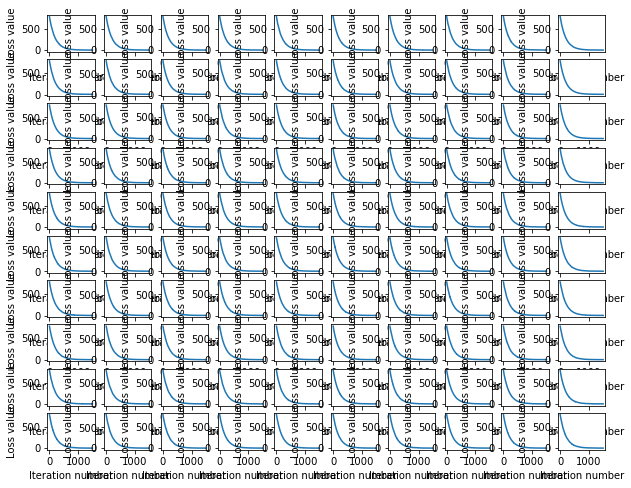

lr 2.956641e-07 reg 2.923669e+04 train accuracy: 0.380633 val accuracy: 0.386000
lr 2.956641e-07 reg 3.065730e+04 train accuracy: 0.379082 val accuracy: 0.375000
lr 2.956641e-07 reg 3.151897e+04 train accuracy: 0.377408 val accuracy: 0.373000
lr 2.956641e-07 reg 3.276638e+04 train accuracy: 0.381939 val accuracy: 0.388000
lr 2.956641e-07 reg 3.360707e+04 train accuracy: 0.384857 val accuracy: 0.394000
lr 2.956641e-07 reg 3.396888e+04 train accuracy: 0.378122 val accuracy: 0.371000
lr 2.956641e-07 reg 3.404719e+04 train accuracy: 0.380490 val accuracy: 0.393000
lr 2.956641e-07 reg 3.609672e+04 train accuracy: 0.382612 val accuracy: 0.381000
lr 2.956641e-07 reg 4.630510e+04 train accuracy: 0.378612 val accuracy: 0.396000
lr 2.956641e-07 reg 4.930029e+04 train accuracy: 0.384429 val accuracy: 0.392000
lr 1.740045e-06 reg 2.923669e+04 train accuracy: 0.380673 val accuracy: 0.398000
lr 1.740045e-06 reg 3.065730e+04 train accuracy: 0.385673 val accuracy: 0.387000
lr 1.740045e-06 reg 3.151897

In [49]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
NUM_STEPS = 10
learning_rates = [1e-7, 5e-5]
learning_rates = np.random.rand(NUM_STEPS)*(learning_rates[1]-learning_rates[0]) + learning_rates[0]
regularization_strengths = [2.5e4, 5e4]
regularization_strengths = np.random.rand(NUM_STEPS)*(regularization_strengths[1]-regularization_strengths[0]) + regularization_strengths[0]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
plt.figure()
idx = 1
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                              num_iters=1500, verbose=True)
        # A useful debugging strategy is to plot the loss as a function of
        # iteration number:
        plt.subplot(len(learning_rates), len(regularization_strengths), idx)
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        idx += 1
        # Write the LinearSVM.predict function and evaluate the performance on both the
        # training and validation set
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: {}'.format(training_accuracy))
        y_val_pred = svm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: {}'.format(validation_accuracy))
        results[(lr, rs)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

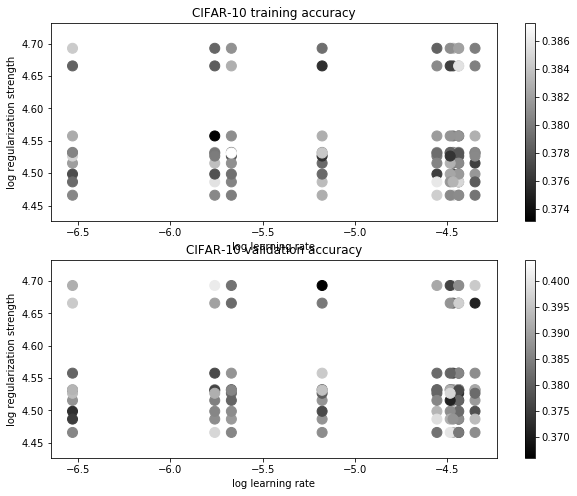

In [50]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [51]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.374000


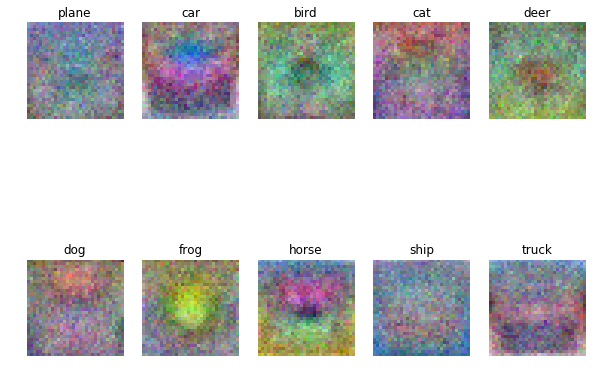

In [52]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *They're just blobs of color where the subject appeared to be. Horses have heads on both sides and no legs. Frogs are green. Highly color dependent. Orientation independent, but it might be problematic if the objects were sheared or rotated.*